## inputs

In [1]:
# path to saved model to be used for SHAP analysis
model_dir = "220924_NN_rand_seed0_ROS"
output_dir = "./shap_figs" # where images will be saved

variants_to_explain = ["KRHWMR", "KRHWMR"]
pams_to_explain = ["NGTG", "NGGG"]
create_summary_plots = True
save_plots = False

## Load info from saved model directory

In [2]:
import shap
import pickle
from functions import *
from tensorflow import keras
import ast
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


# read in the variables that were used during training
with open(model_dir + "/data_parameters.pkl", 'rb') as file:
    vars = pkl.load(file)
run_name, model_name, three_nt_PAM, test_fraction, LOW_RATE_CONSTANT_CUTOFF, LOW_RATE_REPLACE, \
HEATMAP_MAX, HEATMAP_MIN, nts, all_positions, pams = vars
with open(model_dir + "/mean_std.pkl", 'rb') as file:
    DATA_MEAN, DATA_STD = pkl.load(file)

# load model
model = keras.models.load_model(model_dir + "/saved_model")

train = pd.read_csv(model_dir + "/training_data_norm.csv")
print("TRAIN MEAN ", np.mean(train[pams]))
print("TRAIN STD", np.std(np.array(train[pams]).flatten()))
x_train = train["muts_encoded"]

x_train = np.stack([np.fromstring(x_train[i].strip("[]"), dtype = int, sep = '. ') for i in range(len(x_train))])


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


TRAIN MEAN  -0.002684225017806034
TRAIN STD 0.9938601017347134


## Encode training data, subsample and create Deep Explainer

In [3]:
# get features & onehot encoding (mutates input df) for the variants we want to explain
muts_df = pd.DataFrame([list(mut) for mut in variants_to_explain], columns=all_positions, index=variants_to_explain)


enc = add_onehot(muts_df, 
                ['D1135', 'S1136', 'G1218','E1219', 'R1335', 'T1337'],
                encoder=None)
aas = add_onehot(muts_df, ['D1135', 'S1136', 'G1218','E1219', 'R1335', 'T1337'], return_aas=True)

feature_names = get_full_feature_names(['D1135', 'S1136', 'G1218','E1219', 'R1335', 'T1337'], [aas for _ in range(6)])
short_feature_names = [name[0:5] + name[6] for name in feature_names] # remove underscore


to_explain = np.stack([np.array(element) for element in muts_df["muts_encoded"]])
print(to_explain.shape)

Xsamp = shap.utils.sample(x_train, 200) 

explainer = shap.DeepExplainer(model, Xsamp)

shap_values_xsamp = explainer.shap_values(Xsamp)


(2, 120)


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2024-08-06 13:23:09.810936: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Create summary plots for most important features across training examples

NGAA


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


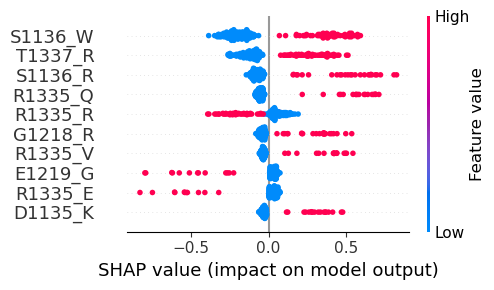

NGAC


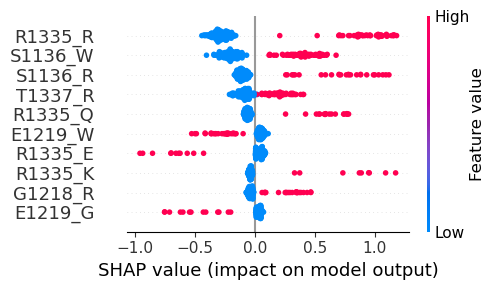

NGAG


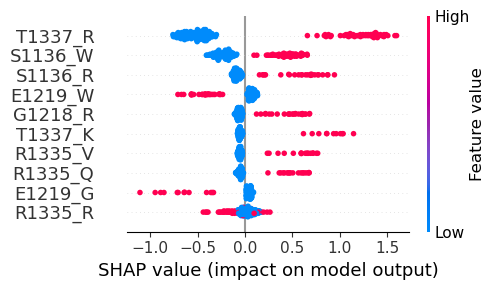

NGAT


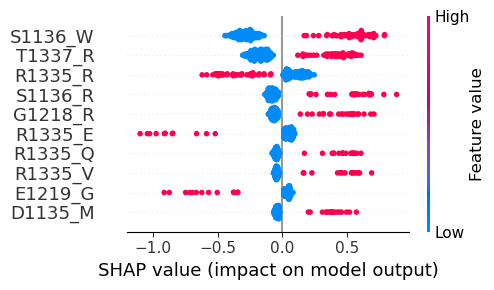

NGCA


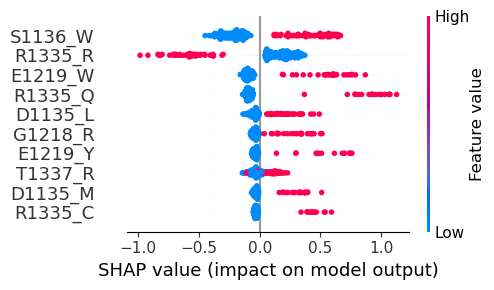

NGCC


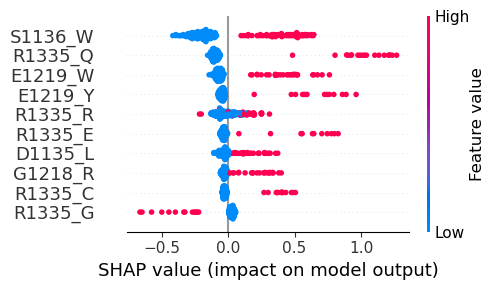

NGCG


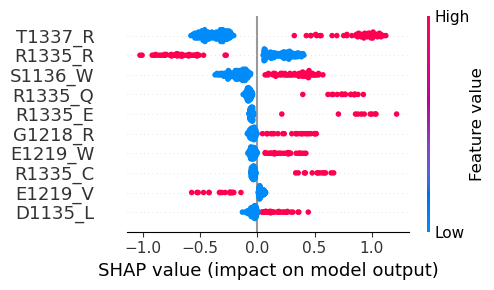

NGCT


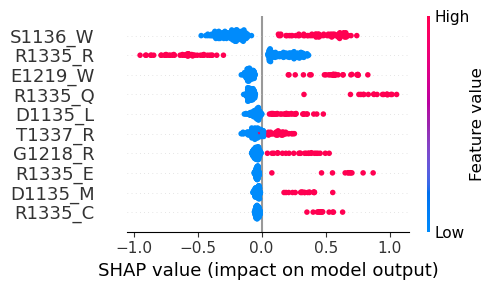

NGGA


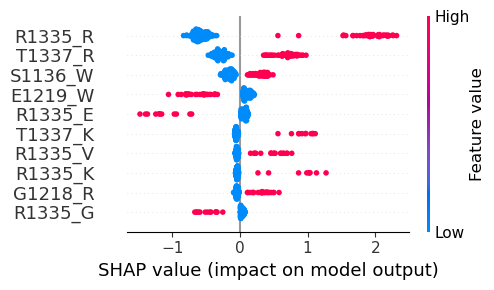

NGGC


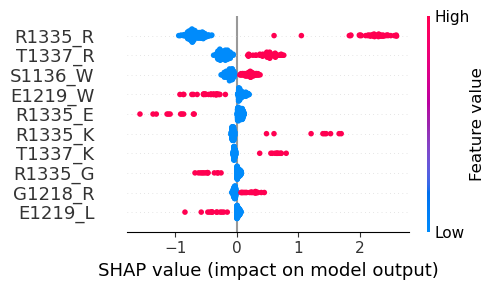

NGGG


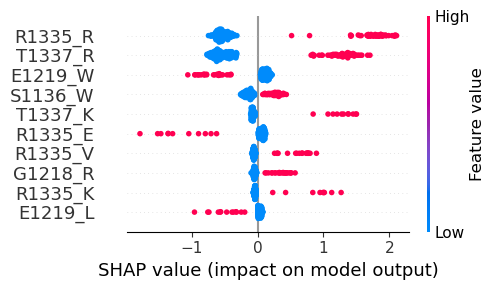

NGGT


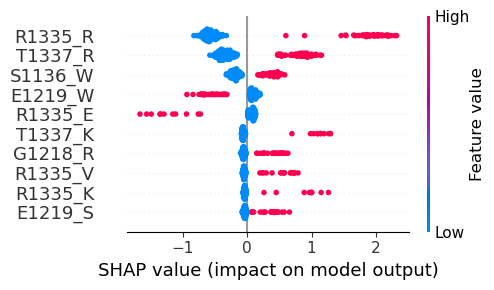

NGTA


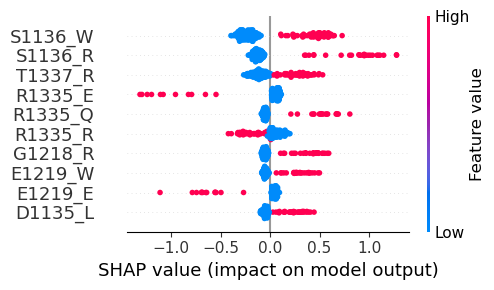

NGTC


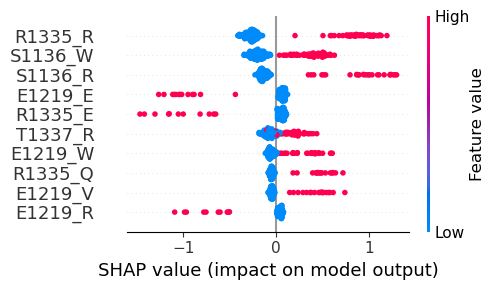

NGTG


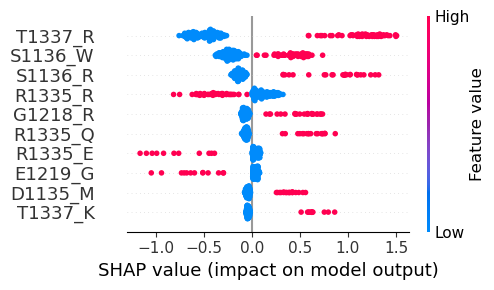

NGTT


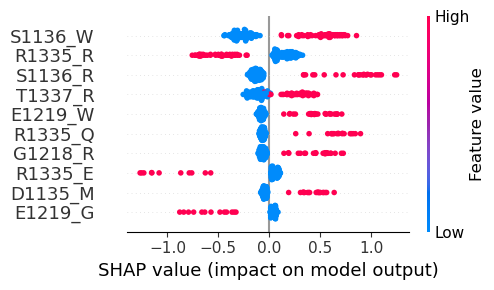

In [4]:
# beeswarm summary plots

for pam in pams[32:48]:

    pam_idx = pams.index(pam)

    print(pam)
    shap.summary_plot(shap_values_xsamp[pam_idx],
                              plot_type="dot",
                              max_display = 10,
                              plot_size=[5,3],
                              feature_names = feature_names,
                              features = Xsamp)

    if save_plots:
                shap.summary_plot(shap_values_xsamp[pam_idx],
                              plot_type="dot",
                              max_display = 10,
                              plot_size=[5,3],
                              feature_names = feature_names,
                              features = Xsamp,
                              show=False)
                p = plt.gcf()
                if not os.path.isdir(output_dir):
                    os.mkdir(output_dir)
                p.savefig(output_dir + "/shap_beeswarm_%s.svg" % (str(pam)))
                plt.clf()


[[32, 36, 40, 44], [33, 37, 41, 45], [34, 38, 42, 46], [35, 39, 43, 47]]


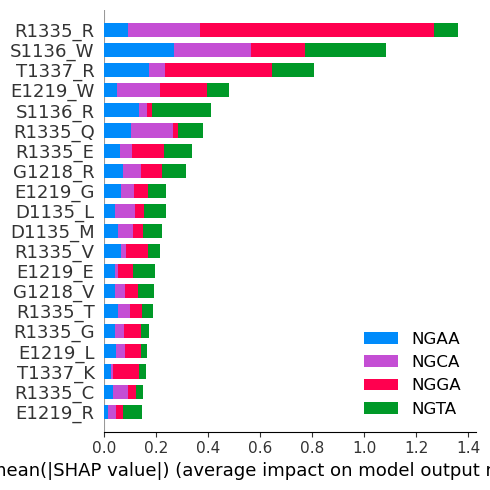

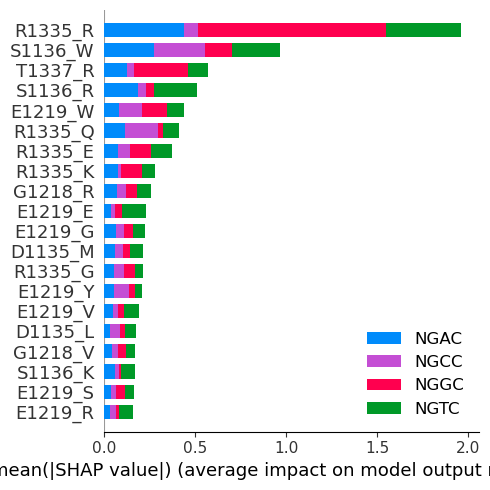

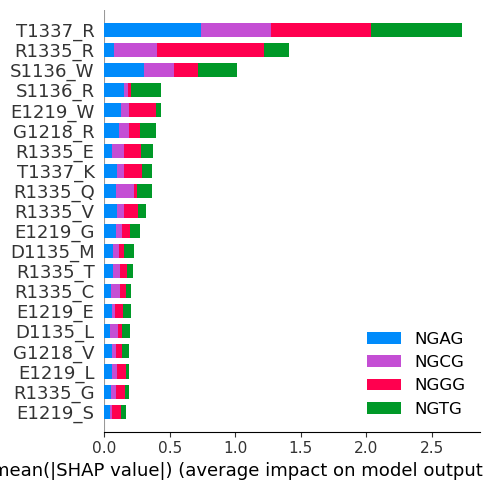

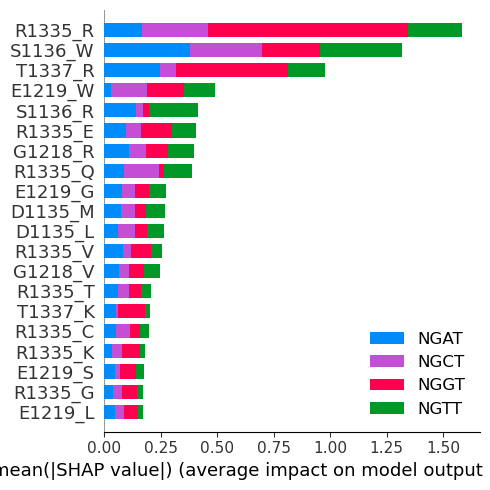

In [5]:
# bar summary plots

pam_groups = [["NGAA", "NGCA", "NGGA", "NGTA"], 
              ["NGAC", "NGCC", "NGGC", "NGTC"],
              ["NGAG", "NGCG", "NGGG", "NGTG"],
              ["NGAT", "NGCT", "NGGT", "NGTT"]]


pam_groups_idx = [[pams.index(element) for element in pam_group] for pam_group in pam_groups]
print(pam_groups_idx)



def create_summary_plots(explainer, Xsamp, pam_groups, pam_groups_idx, output_dir):
    shap_values_all = explainer.shap_values(Xsamp)
    


    for i in range(len(pam_groups)):
        pam_group = pam_groups[i]
        pam_group_idx = pam_groups_idx[i]
        
                                      
        shap.summary_plot([shap_values_all[x] for x in pam_group_idx],
                          feature_names = feature_names, 
                          max_display = 20,
                          plot_size=[5,5], 
                          class_names=pam_group,
                          class_inds=range(len(pam_group)))
        
        if save_plots:
            shap.summary_plot([shap_values_all[x] for x in pam_group_idx],
                              feature_names = feature_names, 
                              max_display = 20,
                              plot_size=[5,5], 
                              class_names=pam_group,
                              class_inds=range(len(pam_group)),
                              show=False)
            p = plt.gcf()
            if not os.path.isdir(output_dir):
                os.mkdir(output_dir)
            p.savefig(output_dir + "/shap_summary_%s.svg" % (str(pam_group)))
            plt.clf()

if create_summary_plots:
    create_summary_plots(explainer, Xsamp, pam_groups, pam_groups_idx, output_dir)

## Explain activity of "to_explain" variants on PAMs of interest

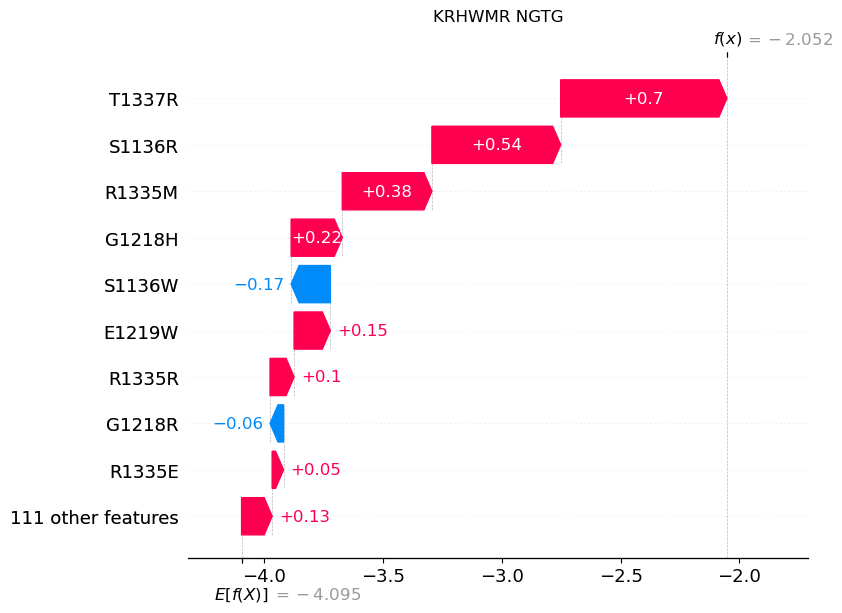

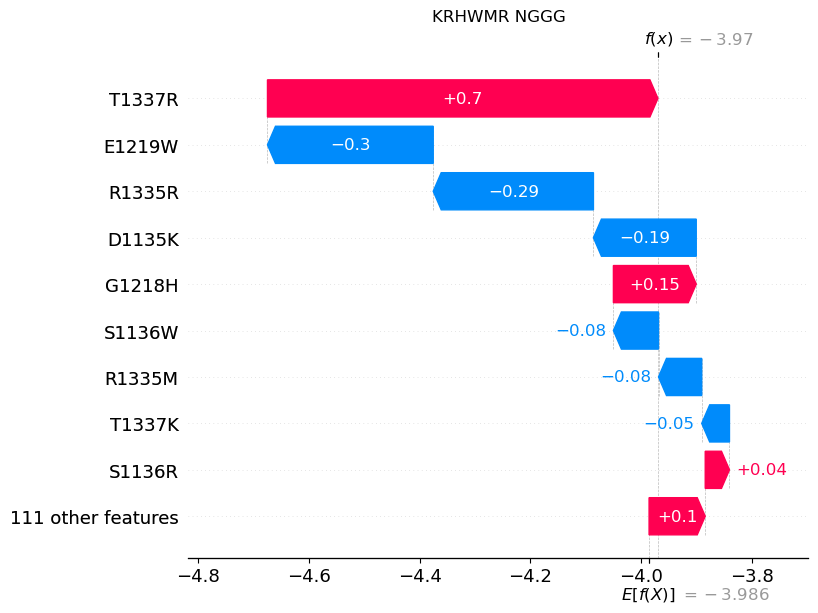

In [6]:
shap_values_to_exp = explainer.shap_values(to_explain)

short_feature_names = [name[0:5] + name[6] for name in feature_names] # remove underscore




for i in range(len(variants_to_explain)):
    var_name = variants_to_explain[i]
    pam_to_explain = pams_to_explain[i]
    plt.title(var_name + " " + pam_to_explain)
    pam_ind = pams.index(pam_to_explain)
    shap.plots._waterfall.waterfall_legacy(unnormalize(explainer.expected_value[pam_ind].numpy(), DATA_MEAN, DATA_STD), 
                                           np.multiply(shap_values_to_exp[pam_ind][i], DATA_STD),
                                           feature_names = short_feature_names, max_display=10)
    if save_plots:
        shap.plots._waterfall.waterfall_legacy(unnormalize(explainer.expected_value[pam_ind].numpy(), DATA_MEAN, DATA_STD), 
                                               np.multiply(shap_values_to_exp[pam_ind][i], DATA_STD),
                                               feature_names = short_feature_names, max_display=10,
                                               show=False)

        p = plt.gcf()
        if not os.path.isdir(output_dir):
                os.mkdir(output_dir)
        p.savefig(output_dir + "/%s_%s.svg" % (var_name, pam_to_explain))
        plt.clf()

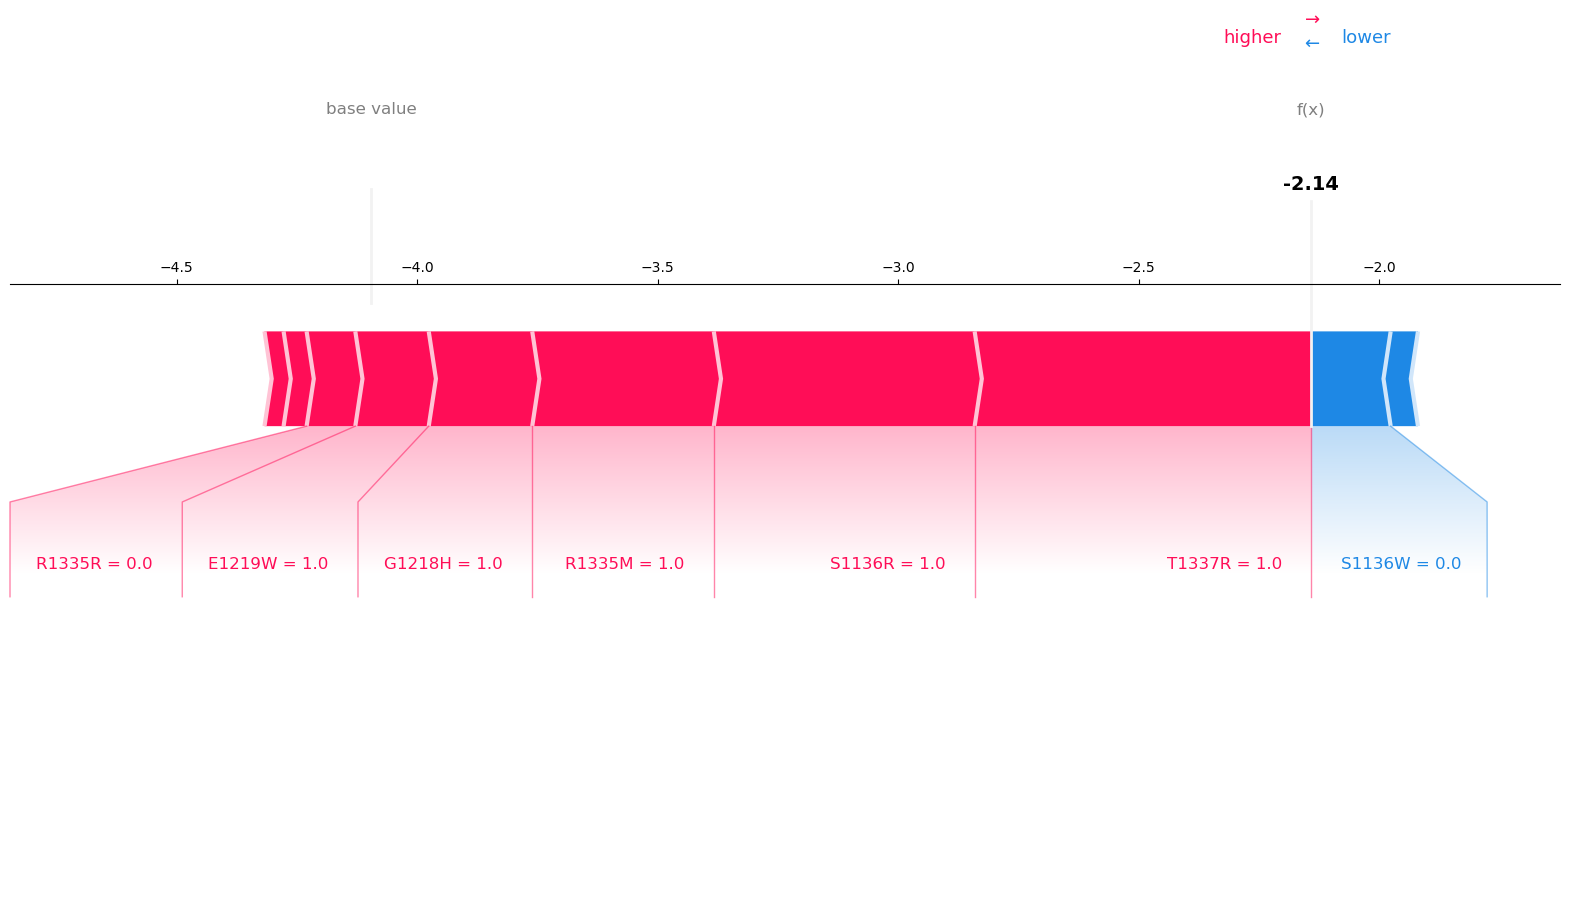

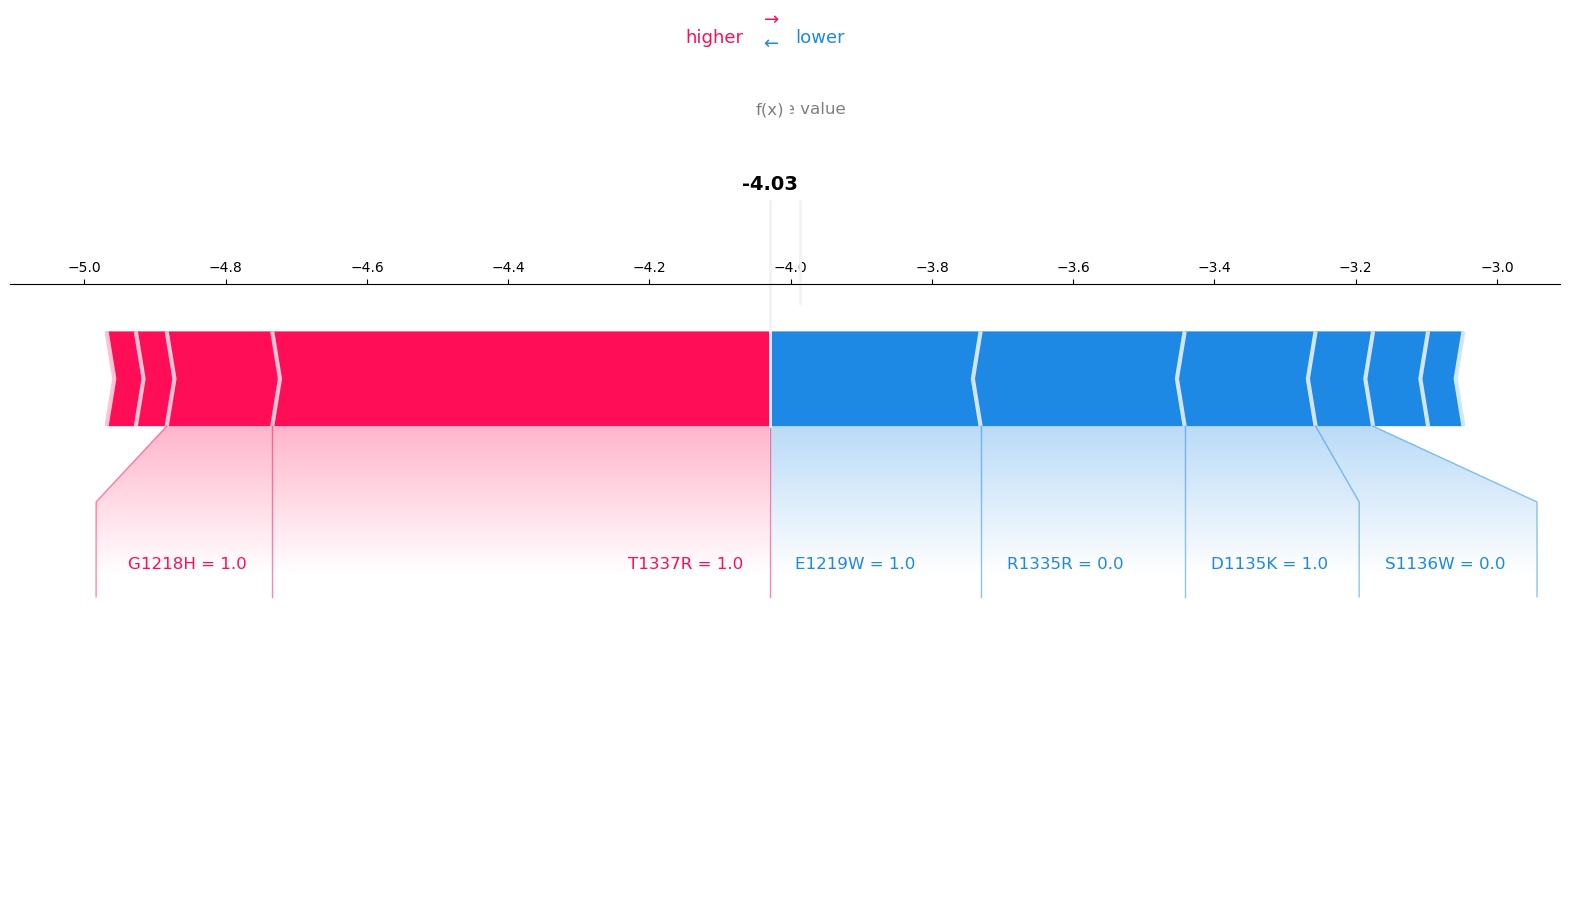

In [7]:
short_feature_names = [name[0:5] + name[6] for name in feature_names] # remove underscore


for i in range(len(variants_to_explain)):
    var_name = variants_to_explain[i]
    pam_to_explain = pams_to_explain[i]
    pam_ind = pams.index(pam_to_explain)
    sv = shap_values_to_exp[pam_ind][i]
    top_ind = np.argsort(np.absolute(sv))[-10:] # get only the top 10 features
    top_sv = sv[top_ind]
    top_feat = np.array(short_feature_names)[top_ind]
    shap.force_plot(unnormalize(explainer.expected_value[pam_ind].numpy(), DATA_MEAN, DATA_STD),
                   np.multiply(top_sv, DATA_STD),
                   features = to_explain[i][top_ind],
                   feature_names = top_feat,
                    figsize=(20, 8),
                   matplotlib=True,
                   show=True)
    
